Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [ ]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [ ]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Read the data into a string.

In [ ]:
import sys
sys.path.insert(0,"/hdd/tensorflow/tensorflow/python/util")
import compat as cp
def read_data(filename):
  f = zipfile.ZipFile(filename)
  for name in f.namelist():
    return cp.as_str(f.read(name)).split() #tf.compat.as_str(f.read(name)).split()   
  f.close()
  
words = read_data(filename)
print('Data size %d' % len(words))

Build the dictionary and replace rare words with UNK token.

In [58]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary
import pickle
try:
  fname = 'data_n_voc.pickle'
  with open(fname,'wb') as f:
    pickle.load([data, count, dictionary, reverse_dictionary],f)
except:
  with open(fname,'rb') as f:
    data, count, dictionary, reverse_dictionary = build_dataset(words)
    pickle.dump([data, count, dictionary, reverse_dictionary],f)
  

print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [ ]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

Train a skip-gram model.

In [ ]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), name='embeddings')
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)),name='softmax_weights')
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]), name='softmax_biases')
  
  saver = tf.train.Saver()
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [ ]:
num_steps = 100001
chkpt_name = 'cbow_1.chkpt'

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    try:
      saver.restore(session, chkpt_name)
      print("Model restored.")
    except:
      print('Model not restored. Cant find that file or smth else!')
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()
  save_path = saver.save(session, chkpt_name)
  print("Model saved in file: %s" % save_path)

In [ ]:
num_points = 400

final_emb_fix = final_embeddings[1:num_points+1, :]
final_emb_fix = np.asfarray( final_emb_fix, dtype='float' )
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_emb_fix)

In [ ]:
%matplotlib inline
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to Word2Vec is called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

## CBOW

In [55]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [56]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [57]:
import sys
sys.path.insert(0,"/hdd/tensorflow/tensorflow/python/util")
import compat as cp
def read_data(filename):
  f = zipfile.ZipFile(filename)
  for name in f.namelist():
    return cp.as_str(f.read(name)).split() #tf.compat.as_str(f.read(name)).split()   
  f.close()
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [58]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary
import pickle
try:
  fname = 'data_n_voc.pickle'
  with open(fname,'wb') as f:
    pickle.load([data, count, dictionary, reverse_dictionary],f)
except:
  with open(fname,'rb') as f:
    data, count, dictionary, reverse_dictionary = build_dataset(words)
    pickle.dump([data, count, dictionary, reverse_dictionary],f)
  

print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [59]:
data_index = 0

def generate_batch(batch_size, n_prev, n_post):
  global data_index
  assert n_prev>0 or n_post>0
  batch = np.ndarray(shape=(batch_size,n_prev+n_post), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  
  span = n_prev + 1 + n_post 
  for i in xrange(batch_size):
    j=0
    while j < n_prev:
      batch[i,j]=data[data_index+j]
      j = j + 1
    labels[i]=data[data_index+j]
    while j < n_prev+n_post:
      batch[i,j]=data[data_index+j+1]
      j = j + 1     
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for n_prev, n_post in [(1, 1), (1, 2),(2,2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, n_prev=n_prev, n_post=n_post)
    print('\nwith prev = %d and post = %d:' % (n_prev, n_post))
    for i in xrange(8):
      print('    batch:', [reverse_dictionary[bi] for bi in batch[i,:]])
      print('    label:', [reverse_dictionary[li] for li in labels[i,:]])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with prev = 1 and post = 1:
    batch: ['anarchism', 'as']
    label: ['originated']
    batch: ['originated', 'a']
    label: ['as']
    batch: ['as', 'term']
    label: ['a']
    batch: ['a', 'of']
    label: ['term']
    batch: ['term', 'abuse']
    label: ['of']
    batch: ['of', 'first']
    label: ['abuse']
    batch: ['abuse', 'used']
    label: ['first']
    batch: ['first', 'against']
    label: ['used']

with prev = 1 and post = 2:
    batch: ['anarchism', 'as', 'a']
    label: ['originated']
    batch: ['originated', 'a', 'term']
    label: ['as']
    batch: ['as', 'term', 'of']
    label: ['a']
    batch: ['a', 'of', 'abuse']
    label: ['term']
    batch: ['term', 'abuse', 'first']
    label: ['of']
    batch: ['of', 'first', 'used']
    label: ['abuse']
    batch: ['abuse', 'used', 'against']
    label: ['first']
    batch: ['first', 'against', 'early']
    label: ['used']

with prev = 2 and pos

Train a CBOW model.

In [60]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
n_prev = 2 # How many words to consider left and right.
n_post = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size,n_prev+n_post])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), name='embeddings')
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)),name='softmax_weights')
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]), name='softmax_biases')
  
  saver = tf.train.Saver()
  
  # Model.
  # calculating mean fow input vectors of context words:
  train_mean = tf.reduce_mean(train_dataset,1)
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_mean)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [64]:
num_steps = 100001
chkpt_name = 'cbow_1.chkpt'

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  try:
      saver.restore(session, chkpt_name)
      print("Model restored.")
  except:
      print('Model not restored. Cant find that file or smth else!')
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, n_prev, n_post)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()
  save_path = saver.save(session, chkpt_name)
  print("Model saved in file: %s" % save_path)

Model not restored. Cant find that file or smth else!
Initialized
Average loss at step 0: 7.852509
Nearest to of: ass, interwoven, ilm, bankrupt, danse, ati, reborn, ringed,
Nearest to american: dial, pitaka, jungle, dix, visibility, seizes, ahab, nitrogenous,
Nearest to would: toll, opportunities, permission, structured, playlists, cardiology, tanakh, authentically,
Nearest to d: disappearing, criticisms, hilary, interactivity, naghten, wissenschaft, marini, huns,
Nearest to or: provers, episode, westphalia, rca, livelihood, fortunate, leclerc, waterfront,
Nearest to their: tights, bau, stagecoach, lanes, campaigns, dick, mattress, activating,
Nearest to four: quan, bruises, timescale, raleigh, jsf, subnational, welded, supernaturally,
Nearest to are: swinging, doolittle, clip, yemen, liable, parameters, gilbertese, roving,
Nearest to this: mifune, uwe, comprehended, recipient, salom, ethica, limnic, tanaka,
Nearest to system: meteora, idempotent, extensionality, athos, xix, bendis, k

NameError: name 'sess' is not defined

In [65]:
num_points = 400

final_emb_fix = final_embeddings[1:num_points+1, :]
final_emb_fix = np.asfarray( final_emb_fix, dtype='float' )
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_emb_fix)

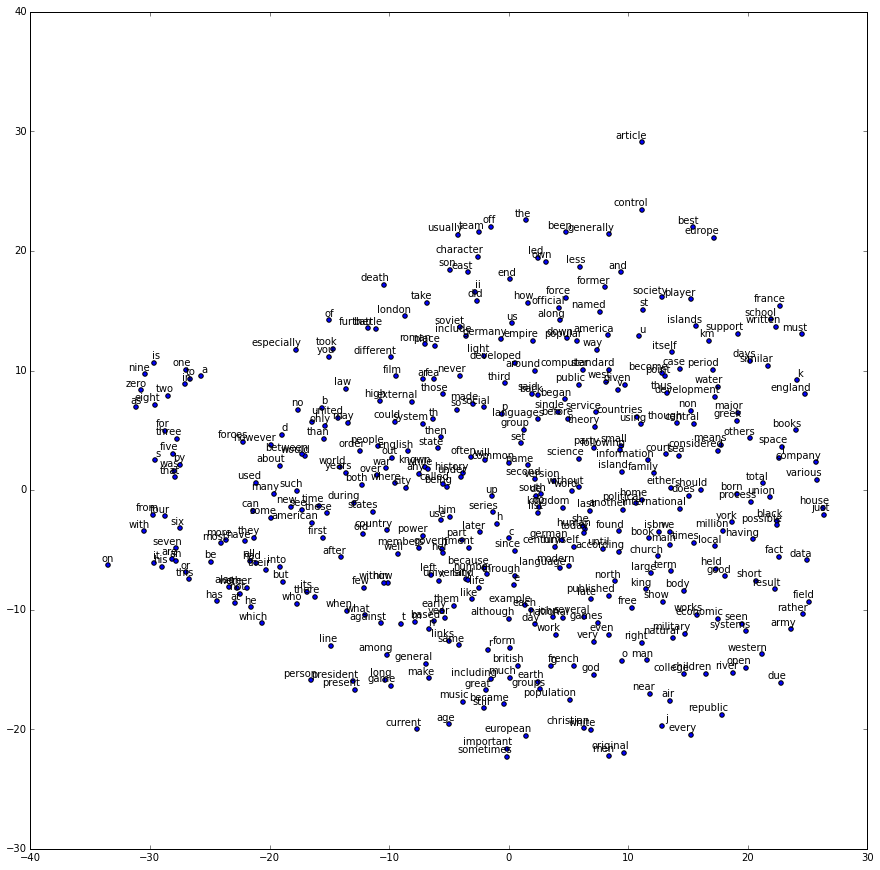

In [66]:
%matplotlib inline
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)